In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random
from collections import namedtuple, deque

from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from replay_memory import ReplayMemory
from experience import Experience, get_fields_from_experiences
from utils import plot_scores

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

seed = 5
random.seed(seed)
torch.manual_seed(seed)
print('Seed:', seed)

Device: cuda:0
Seed: 5


In [4]:
env = UnityEnvironment(file_name='VisualBanana_Linux/Banana.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain name:', brain_name)

env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.visual_observations[0]
print('State example:')
print(state)

state_size = state.shape
print('State size:', state.shape)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Brain name: BananaBrain
Number of agents: 1
Number of actions: 4
State example:
[[[[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  [[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  [[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  ...

  [[0.39215686 0.34117647 0.2745098 ]
   [0.39215686 0.34117647 0.2745098 ]
   [0.39215686 0.34117647 0.2745098 ]
   ...
   [0.21568627 0.17647059 0.5254902 ]
   [0.17254902 0.15294118 0.38039216]
   [0

Original shape: (1, 84, 84, 3)
Processed shape: (1, 1, 44, 84)


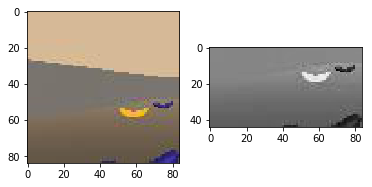

In [5]:
import matplotlib.pyplot as plt

def preprocess(state):
    R = state[:, 40:, :, 0]
    G = state[:, 40:, :, 1]
    B = state[:, 40:, :, 2]
    L = 0.2126 * R + 0.7152 * G + 0.0722 * B
    return np.expand_dims(L, 0)
    
def demo_preprocess(state):
    print('Original shape:', state.shape)
    
    processed = preprocess(state)
    print('Processed shape:', processed.shape)
    
    fig, axs = plt.subplots(ncols=2, nrows=1)
    axs[0].imshow(np.squeeze(state))
    axs[1].imshow(np.squeeze(processed), cmap='gray')
    

demo_preprocess(state)

In [6]:
st = np.concatenate([preprocess(state), preprocess(state), preprocess(state)], axis=1)
print(st.shape)

(1, 3, 44, 84)


In [7]:
st = preprocess(state)
np.repeat(st, 3, axis=1).shape

(1, 3, 44, 84)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelQNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(PixelQNet, self).__init__()
    
        self.conv1 = torch.nn.Conv2d(4, 32, 8, 4)
        self.conv2 = torch.nn.Conv2d(32, 64, 4, 2)
        self.conv3 = torch.nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 2 * 7, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, state):
        x = state
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 64 * 2 * 7)
        x = F.relu(self.fc1(x))
      
        return self.fc2(x)

In [ ]:
class PixelAgent:
    def __init__(self, 
                 state_size, 
                 action_size,
                 discount_factor,
                 memory_size,
                 batch_size, 
                 replay_start,
                 learn_freq,                 
                 learn_rate,
                 target_update_freq,
                 soft_update_factor
                ):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.replay_start = replay_start
  
        self.learn_freq = learn_freq
        self.learn_rate = learn_rate
        
        self.target_update_freq = target_update_freq
        self.soft_update_factor = soft_update_factor
      
        self.local_model = PixelQNet(state_size, action_size).to(device)
        self.target_model = PixelQNet(state_size, action_size).to(device)
        self.optimizer = optim.RMSprop(self.local_model.parameters(), lr=learn_rate)
        self.memory = ReplayMemory(memory_size, batch_size)
        
        self.learn_step = 0
        self.target_update_step = 0 
    
    def perceive(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.memory.add(experience)
        
        self.learn_step = (self.learn_step + 1) % self.learn_freq
        
        if self.learn_step == 0 and len(self.memory) >= self.replay_start:
            self.learn()

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().to(device)
    
        self.local_model.eval()
        
        with torch.no_grad():
            action_values = self.local_model(state)
        
        self.local_model.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = get_fields_from_experiences(experiences, device)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + self.discount_factor * Q_targets_next * (1 - dones)
        # Get expected Q values from local model
        Q_expected = self.local_model(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update of target model: θ_target = τ*θ_local + (1 - τ)*θ_target
        self.target_update_step = (self.target_update_step + 1) % self.target_update_freq
        
        if self.target_update_step == 0:            
            for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
                target_param.data.copy_(
                    self.soft_update_factor * local_param.data + (1.0 - self.soft_update_factor) * target_param.data)

In [ ]:
def train(
    agent,
    max_episodes, # (int): maximum number of training episodes
    max_steps, # (int): maximum number of steps per episode
    goal_score, # (int): average score to achive over 100 episodes 
    epsilon_start, # (float): start value of epsilon, for epsilon-greedy action selection
    epsilon_end, # (float): minimum value of epsilon
    epsilon_decay, # (float): multiplicative factor (per episode) for decreasing epsilon,
    action_repeat,
    model_path
):
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    epsilon = epsilon_start # initialize epsilon
    
    for episode in range(1, max_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = np.repeat(preprocess(env_info.visual_observations[0]), action_repeat, axis=1) # initial state
        score = 0 # initialize the score
        
        for step in range(max_steps):
            if step % action_repeat == 0:
                action = agent.act(state, epsilon)
                
                if step > 0:
                    next_state = np.concatenate(observations, axis=1)
                    agent.perceive(state, action, reward, next_state, done)
                    
                    state = next_state
                    score += reward
                    
                observations = []          
                reward = 0
                done = False
                 
            env_info = env.step(action)[brain_name] # send the action to the environment
            observations.append(preprocess(env_info.visual_observations[0])) # get the next state
            reward += env_info.rewards[0] # get the reward
            done = done or env_info.local_done[0] # see if episode has finished
            
            if done:
                break
        
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        epsilon = max(epsilon_end, epsilon_decay * epsilon) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end='')
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= goal_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_window)))
            torch.save(agent.local_model.state_dict(), model_path)
            break
    
    return scores

agent = PixelAgent(
    state_size=state_size, 
    action_size=action_size,
    memory_size=int(1e5),
    batch_size=64,
    discount_factor=0.99,
    replay_start=1000,
    learn_freq=4,
    learn_rate=5e-4,
    target_update_freq=500,
    soft_update_factor=1e-3
)

scores = train(
    agent=agent,  
    max_episodes=2000, 
    max_steps=2000, 
    goal_score=13,
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay=0.995,
    action_repeat=4,
    model_path='models/pixel_qnet.pth'
)

plot_scores(scores)

Episode 100	Average Score: 0.04
Episode 200	Average Score: 0.28
Episode 300	Average Score: -0.08
Episode 400	Average Score: 0.153
Episode 500	Average Score: 0.15
Episode 600	Average Score: 0.04
Episode 700	Average Score: -0.02
Episode 800	Average Score: -0.10
Episode 900	Average Score: -0.25
Episode 940	Average Score: -0.05

In [11]:
# def test(agent, epsilon=0.05):
#     env_info = env.reset(train_mode=False)[brain_name] # reset the environment
#     state = preprocess(env_info.visual_observations[0]) # get the current state
#     score = 0 # initialize the score

#     while True:
#         action = agent.act(state, epsilon) # select an action
#         env_info = env.step(action)[brain_name] # send the action to the environment
#         next_state = preprocess(env_info.visual_observations[0]) # get the next state
#         reward = env_info.rewards[0] # get the reward
#         done = env_info.local_done[0] # see if episode has finished
#         score += reward # update the score
#         state = next_state # roll over the state to next time step
        
#         if done: # exit loop if episode finished
#             break
    
#     print("Score: {}".format(score))
    
# test(agent)

In [12]:
#env.close()